# Lab - Cross Validation

For this lab, we will build a model on customer churn binary classification problem. You will be using files_for_lab/Customer-Churn.csv file.

## Import Libraries

In [89]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

import seaborn as sns

## Import Dataframe

In [59]:
data = pd.read_csv(r'files_for_lab\Customer-Churn.csv',encoding='latin-1')

In [60]:
data.shape

(7043, 16)

In [61]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


## Cleaning

### Clean dtypes

In [62]:
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [63]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [64]:
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

### Clean Null Values

In [65]:
data.isna().any()

gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
MonthlyCharges      False
TotalCharges         True
Churn               False
dtype: bool

In [66]:
percent_missing = data.isnull().sum() * 100 / len(data)

In [67]:
print(round(percent_missing,2))

gender              0.00
SeniorCitizen       0.00
Partner             0.00
Dependents          0.00
tenure              0.00
PhoneService        0.00
OnlineSecurity      0.00
OnlineBackup        0.00
DeviceProtection    0.00
TechSupport         0.00
StreamingTV         0.00
StreamingMovies     0.00
Contract            0.00
MonthlyCharges      0.00
TotalCharges        0.16
Churn               0.00
dtype: float64


due to an insignificant amount of missing values I will drop the null rows

In [68]:
data = data.dropna()

In [69]:
data.shape

(7032, 16)

11 rows have been dropped

### Encode categoricals values

In [70]:
# split in numerical and categorical variables

num_df = data.select_dtypes(include = np.number)
cat_df = data.select_dtypes(include = object).drop(['Churn'], axis=1)
target_df = data['Churn']

In [71]:
# encode categorical variables
cat_df = pd.get_dummies(cat_df, drop_first=True)

In [72]:
cat_df

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year
0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,1,1,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0
7039,0,1,1,1,0,0,0,1,0,1,0,0,0,1,0,1,1,0
7040,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7041,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
# check shape of numerical & categorical variables
num_df.shape , cat_df.shape, target_df.shape

((7032, 4), (7032, 18), (7032,))

In [77]:
# merge categorical and numerical variables to model dataframe
# review model dataframe
model_df = pd.merge(cat_df, num_df, left_index=True, right_index=True)
model_df = pd.merge(model_df, target_df, left_index=True, right_index=True)
model_df

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,29.85,29.85,No
1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,34,56.95,1889.50,No
2,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,53.85,108.15,Yes
3,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,45,42.30,1840.75,No
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,1,1,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,24,84.80,1990.50,No
7039,0,1,1,1,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,72,103.20,7362.90,No
7040,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11,29.60,346.45,No
7041,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,74.40,306.60,Yes


## Apply SMOTE for upsampling the data

In [82]:
smote = SMOTE()

X = model_df.drop('Churn', axis=1)
y = model_df['Churn']

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

Yes    5163
No     5163
Name: Churn, dtype: int64

### Use logistic regression to fit the model and compute the accuracy of the model.

In [83]:
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [84]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_sm_train, y_sm_train)

LogisticRegression(max_iter=10000, random_state=42)

In [85]:
classification.score(X_sm_test, y_sm_test)

0.8097773475314618

### Use decision tree classifier to fit the model and compute the accuracy of the model.

In [86]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, test_size=0.33)
model = DecisionTreeClassifier()
model.fit(X_sm_train, y_sm_train)
model.score(X_sm_test, y_sm_test)

0.7767018779342723

### Compare the accuracies of the two models.

In [87]:
predictions = classification.predict(X_sm_test)
confusion_matrix(y_sm_test, predictions)

array([[1350,  370],
       [ 282, 1406]], dtype=int64)

<AxesSubplot:>

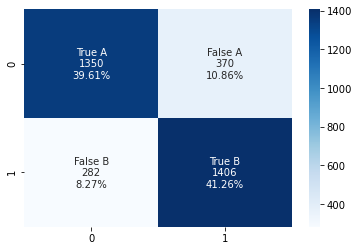

In [90]:
cf_matrix = confusion_matrix(y_sm_test, predictions)
group_names = ['True A', 'False A',
               'False B', 'True B']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## Apply TomekLinks for downsampling

It is important to remember that it does not make the two classes equal but only removes the points from the majority class that are close to other points in minority class.

In [92]:
X = model_df.drop('Churn', axis=1)
y = model_df['Churn']

tomek = TomekLinks()
X_tl, y_tl = tomek.fit_resample(X, y)
y_tl.value_counts()

No     4596
Yes    1869
Name: Churn, dtype: int64

### Use logistic regression to fit the model and compute the accuracy of the model.

In [93]:
X_tl_train, X_tl_test, y_tl_train, y_tl_test = train_test_split(X_tl, y_tl, test_size=0.2, random_state=42)

In [94]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_tl_train, y_tl_train)

LogisticRegression(max_iter=10000, random_state=42)

In [95]:
classification.score(X_tl_test, y_tl_test)

0.8167053364269141

### Use decision tree classifier to fit the model and compute the accuracy of the model.

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_tl_train, X_tl_test, y_tl_train, y_tl_test = train_test_split(X_tl, y_tl, test_size=0.33)
model = DecisionTreeClassifier()
model.fit(X_tl_train, y_tl_train)
model.score(X_tl_test, y_tl_test)

0.739456419868791

### Compare the accuracies of the two models.

In [97]:
predictions = classification.predict(X_tl_test)
confusion_matrix(y_tl_test, predictions)

array([[1329,  181],
       [ 222,  402]], dtype=int64)

<AxesSubplot:>

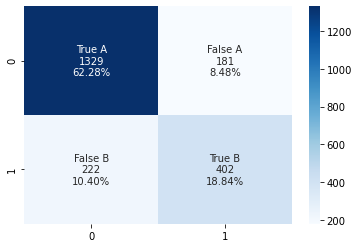

In [98]:
cf_matrix = confusion_matrix(y_tl_test, predictions)
group_names = ['True A', 'False A',
               'False B', 'True B']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### You can also apply this algorithm one more time and check the how the imbalance in the two classes changed from the last time.